In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os

file_count = 0  # counter to track number of files printed

for dirname, _, filenames in os.walk('/kaggle/input/brain-tumor-mri-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        file_count += 1
        if file_count == 10:
            break
    if file_count == 10:
        break


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg


📝 Task Description
Participants are tasked with developing a machine learning or deep learning model that classifies brain tumor images into the appropriate categories. You will work with the provided MRI dataset, which includes images of brain tumors with labeled categories.

The challenge involves:

-Preprocessing the MRI images to extract meaningful features for classification.
-Using the PyTorch framework, implement a classification CNN model to classify between Glioma, Meningioma, Pituitary, and No Tumor.
-Evaluating the model based on its accuracy, precision, and recall, and ensuring it generalizes well to unseen MRI scans.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Check if CUDA is available (for GPU acceleration)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA


1. Custom dataset class to load the MRI dataset

In [37]:
# Custom dataset class for loading brain tumor images
class BrainTumorDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # Get class names sorted (e.g., ['glioma', 'meningioma', 'notumor', 'pituitary'])
        self.classes = sorted([d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))])
        # Create a mapping from class names to numeric labels
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.filepaths = []
        self.labels = []

        # Iterate through each class and collect image paths and labels
        for class_name in self.classes:
            class_path = os.path.join(img_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith((".png", ".jpg", ".jpeg")):  # Filter image files
                    self.filepaths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.filepaths)  # Total number of images

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")  # Load image and ensure RGB
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            raise
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)


2. Proper Transformations for image processing 

In [38]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For validation/testing: only resize and normalize
val_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For raw image visualization (no augmentation)
no_aug_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [39]:
# Dataset root path on Kaggle
dataset_path = '/kaggle/input/brain-tumor-mri-dataset'

# Training and Testing directories
train_dir = os.path.join(dataset_path, 'Training')
test_dir = os.path.join(dataset_path, 'Testing')

# Load dataset with no augmentation for training (initially)
training_dataset = BrainTumorDataset(img_dir=train_dir, transform=train_transforms)
testing_dataset = BrainTumorDataset(img_dir=test_dir, transform=val_transforms)

# Split the testing set into test and validation (70%-30%)
test_size = int(0.7 * len(testing_dataset))
val_size = len(testing_dataset) - test_size

test_dataset, val_dataset = random_split(testing_dataset, [test_size, val_size],
                                         generator=torch.Generator().manual_seed(42))  # Set seed for reproducibility

# Print dataset sizes
print(f"Training Set: {len(training_dataset)}")
print(f"Validation Set: {len(val_dataset)}")
print(f"Testing Set: {len(test_dataset)}")


Training Set: 5712
Validation Set: 394
Testing Set: 917


3. Datasets and Data Loaders for training and validation

In [40]:
from torch.utils.data import DataLoader

# DataLoaders
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class information
class_names = training_dataset.classes
num_classes = len(class_names)

print("=" * 40)
print("🚀 Dataset Summary")
print("=" * 40)
print("Class Names:        ", class_names)
print("Number of Classes:  ", num_classes)
print(f"Training Samples:   {len(training_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Testing Samples:    {len(test_dataset)}")
print("=" * 40)


🚀 Dataset Summary
Class Names:         ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of Classes:   4
Training Samples:   5712
Validation Samples: 394
Testing Samples:    917


<ipython-input-41-45e1ee00cf99>:40: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


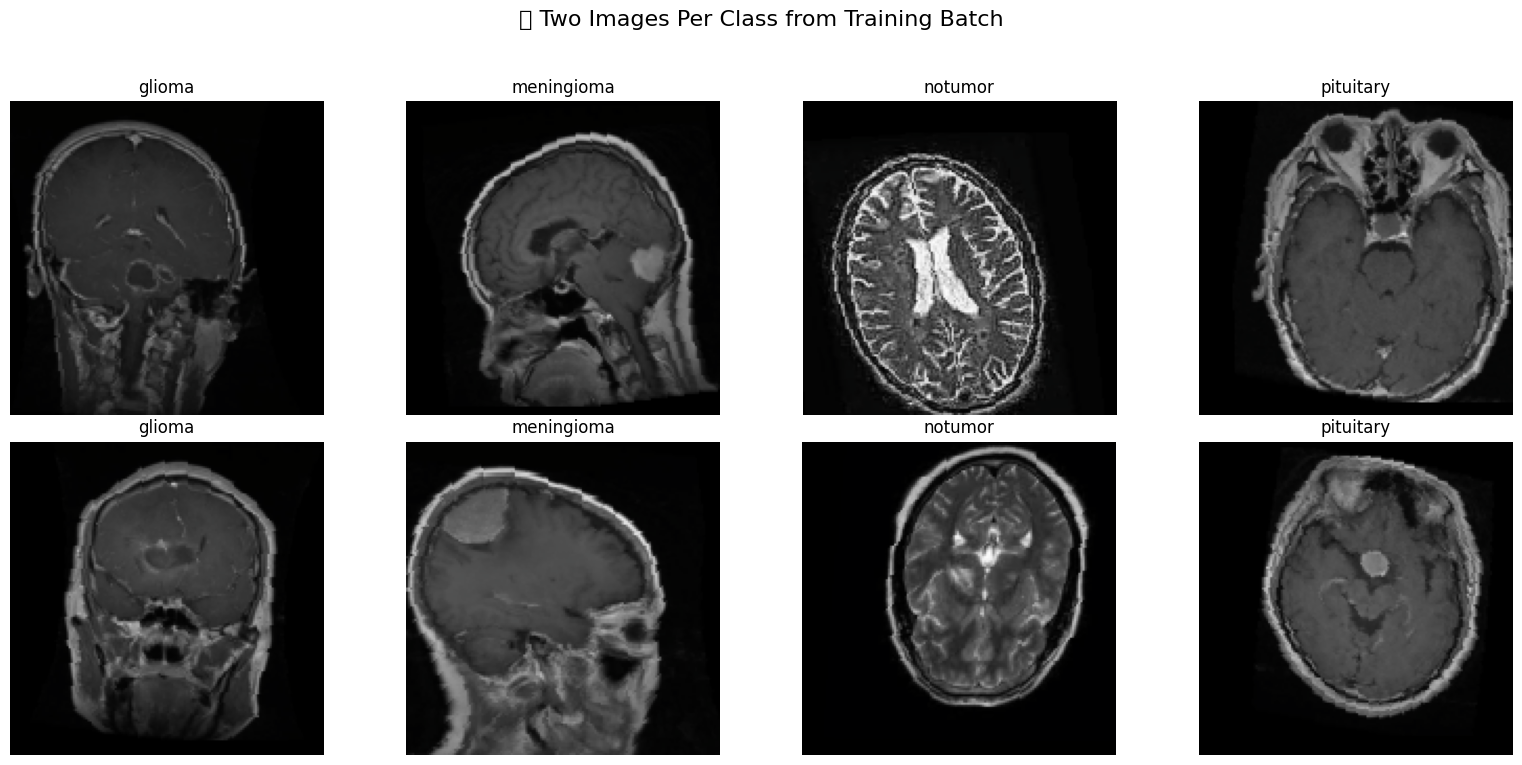

In [41]:
# Function to undo normalization for displaying images
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Load a batch from training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Group images by class for display
images_per_class = 2
class_images = {class_name: [] for class_name in training_dataset.classes}

for i in range(len(labels)):
    label_index = labels[i].item()
    class_name = training_dataset.classes[label_index]
    if len(class_images[class_name]) < images_per_class:
        class_images[class_name].append(images[i])

# Filter to only classes with enough samples
class_images = {k: v for k, v in class_images.items() if len(v) == images_per_class}
num_classes_to_show = len(class_images)

# Display
if num_classes_to_show > 0:
    fig, axes = plt.subplots(images_per_class, num_classes_to_show, figsize=(4 * num_classes_to_show, 4 * images_per_class))
    fig.suptitle("🧠 Two Images Per Class from Training Batch", fontsize=16)

    for col_index, (class_name, img_list) in enumerate(class_images.items()):
        for row_index, img_tensor in enumerate(img_list):
            ax = axes[row_index, col_index]
            ax.imshow(denormalize(img_tensor))
            ax.set_title(class_name, fontsize=12)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("❗ Not enough classes with at least two images in the first batch to display.")


4. Implement a classification algorithm using PyTorch and CNNs for image classification

In [42]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        self.bn0 = nn.BatchNorm2d(3)  # Normalize input image

        # First Conv Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.20)

        # Second Conv Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.20)

        # Third Conv Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(256, 128)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 64)
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.bn0(x)
    
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.bn1(x)
        x = self.dropout1(x)
    
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.bn2(x)
        x = self.dropout2(x)
    
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.bn3(x)
        x = self.dropout3(x)
    
        x = self.flatten(x)
    
        x = self.dropout4(self.bn4(self.relu4(self.fc1(x))))
        x = self.dropout5(self.bn5(self.relu5(self.fc2(x))))
        x = self.bn6(self.relu6(self.fc3(x)))
    
        return self.fc4(x)



5. A suitable loss function for multi-class classification

In [43]:
# Initialize the model
num_classes = 4
model = BrainTumorClassifier(num_classes=num_classes)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Tracking the loss and accuracy metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = correct_predictions / total_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    epoch_val_loss = val_running_loss / val_total
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"[Epoch {epoch+1:02d}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


[Epoch 01/30] Train Loss: 0.7647, Train Acc: 0.7006 | Val Loss: 0.7435, Val Acc: 0.7005
[Epoch 02/30] Train Loss: 0.6120, Train Acc: 0.7617 | Val Loss: 0.7066, Val Acc: 0.7259
[Epoch 03/30] Train Loss: 0.5557, Train Acc: 0.7799 | Val Loss: 0.6387, Val Acc: 0.7589
[Epoch 04/30] Train Loss: 0.5358, Train Acc: 0.7917 | Val Loss: 0.6182, Val Acc: 0.7335
[Epoch 05/30] Train Loss: 0.4964, Train Acc: 0.8072 | Val Loss: 0.6116, Val Acc: 0.7183
[Epoch 06/30] Train Loss: 0.4584, Train Acc: 0.8270 | Val Loss: 0.5232, Val Acc: 0.7741
[Epoch 07/30] Train Loss: 0.4364, Train Acc: 0.8342 | Val Loss: 0.4932, Val Acc: 0.7792
[Epoch 08/30] Train Loss: 0.3976, Train Acc: 0.8489 | Val Loss: 0.5614, Val Acc: 0.7919
[Epoch 09/30] Train Loss: 0.3757, Train Acc: 0.8587 | Val Loss: 0.4448, Val Acc: 0.8071
[Epoch 10/30] Train Loss: 0.3557, Train Acc: 0.8647 | Val Loss: 0.4364, Val Acc: 0.8350
[Epoch 11/30] Train Loss: 0.3294, Train Acc: 0.8789 | Val Loss: 0.4159, Val Acc: 0.8350
[Epoch 12/30] Train Loss: 0.3187

7. Save the trained model and make predictions on unseen MRI images 

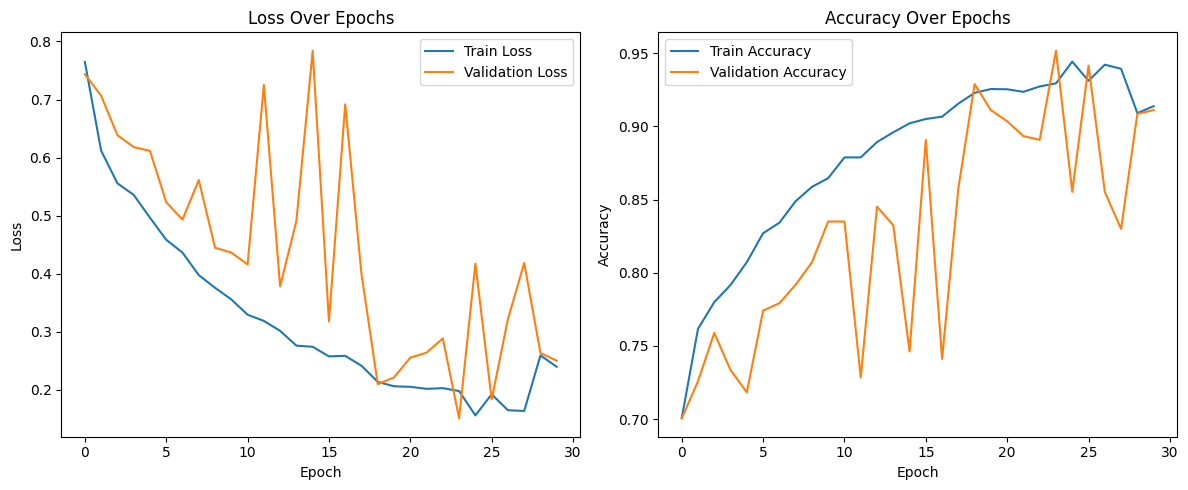

In [44]:
# Plotting Training vs Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
# Save the trained model
MODEL_PATH = "brain_tumor_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': num_classes,
    'epoch': num_epochs,
}, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Load model (example usage)
def load_model(model_class, model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = model_class(num_classes=checkpoint['num_classes'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # set to eval mode
    print(f"Model loaded from {model_path}")
    return model


Model saved to brain_tumor_classifier.pth


8. Evaluation

🖥️ Using device: cuda:0
✅ Test dataset loaded with 1311 images and classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
📂 Loading model from brain_tumor_classifier.pth


<ipython-input-46-e27c115eddc6>:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully!
🔍 Starting model evaluation...

📊 Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.80      0.88       300
  meningioma       0.77      0.89      0.83       306
     notumor       0.93      0.98      0.96       405
   pituitary       0.99      0.95      0.97       300

    accuracy                           0.91      1311
   macro avg       0.92      0.90      0.91      1311
weighted avg       0.92      0.91      0.91      1311



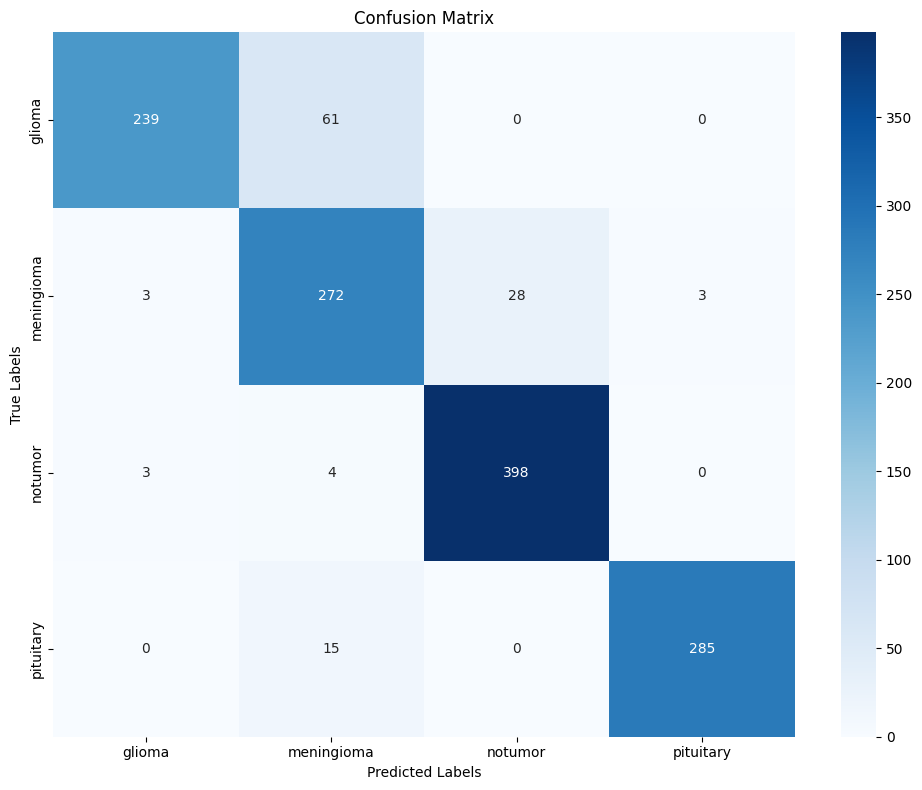

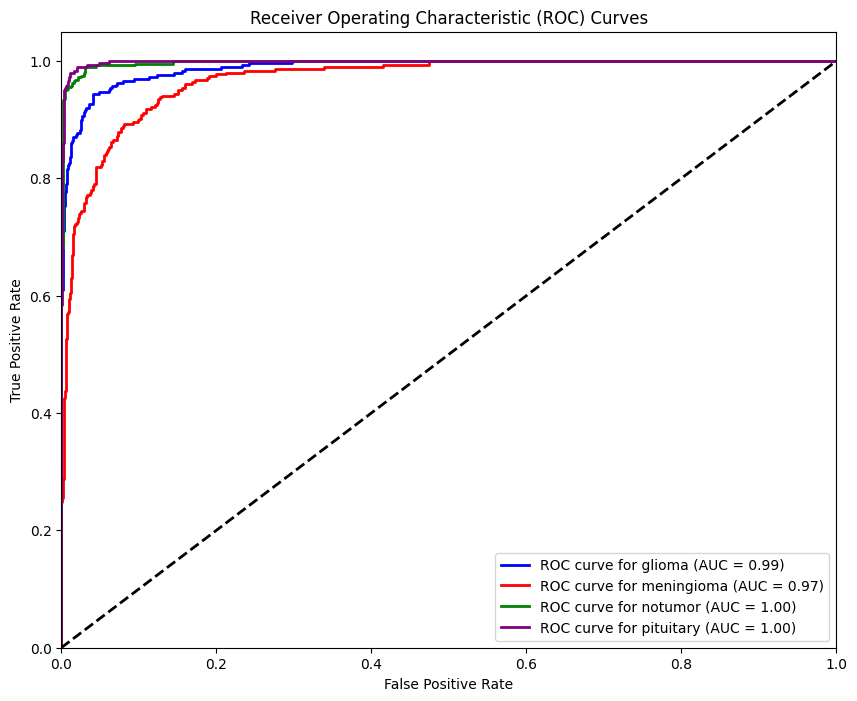


✅ Class-wise Accuracy:
glioma: 0.7967
meningioma: 0.8889
notumor: 0.9827
pituitary: 0.9500

🏁 Overall Accuracy: 0.9108
✅ Evaluation complete! Results saved to 'evaluation_results.txt'


In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn


def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.append(probabilities.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probs = np.concatenate(all_probs)

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # ROC & AUC
    n_classes = len(class_names)
    y_test_bin = label_binarize(all_labels, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple']
    for i, color, cls in zip(range(n_classes), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for {cls} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()

    # Class-wise accuracy
    class_accuracy = {}
    for i, class_name in enumerate(class_names):
        class_indices = np.where(all_labels == i)[0]
        if len(class_indices) > 0:
            class_correct = np.sum(all_predictions[class_indices] == i)
            class_accuracy[class_name] = class_correct / len(class_indices)

    print("\n✅ Class-wise Accuracy:")
    for class_name, accuracy in class_accuracy.items():
        print(f"{class_name}: {accuracy:.4f}")

    # Overall accuracy
    overall_accuracy = np.mean(all_predictions == all_labels)
    print(f"\n🏁 Overall Accuracy: {overall_accuracy:.4f}")

    return {
        'confusion_matrix': cm,
        'classification_report': classification_report(all_labels, all_predictions, target_names=class_names, output_dict=True),
        'roc_auc': roc_auc,
        'overall_accuracy': overall_accuracy,
        'class_accuracy': class_accuracy
    }


# -------- MAIN EXECUTION --------
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"🖥️ Using device: {device}")

    # Load test dataset and extract class names from folders
    test_transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_data_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

    try:
        test_data = datasets.ImageFolder(root=test_data_path, transform=test_transform)
        class_names = test_data.classes
        test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)
        print(f"✅ Test dataset loaded with {len(test_data)} images and classes: {class_names}")
    except Exception as e:
        print(f"❌ Error loading test dataset: {str(e)}")
        exit(1)

    # Load the trained model
    model_path = "brain_tumor_classifier.pth"
    print(f"📂 Loading model from {model_path}")

    try:
        checkpoint = torch.load(model_path, map_location=device)
        model = BrainTumorClassifier(num_classes=len(class_names))
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        exit(1)

    # Run evaluation
    print("🔍 Starting model evaluation...")
    results = evaluate_model(model, test_loader, device, class_names)

    # Save results summary
    with open('evaluation_results.txt', 'w') as f:
        f.write("Brain Tumor Classification Model Evaluation Results\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Overall Accuracy: {results['overall_accuracy']:.4f}\n\n")
        f.write("Class-wise Accuracy:\n")
        for class_name, accuracy in results['class_accuracy'].items():
            f.write(f"{class_name}: {accuracy:.4f}\n")
        f.write("\nROC AUC Scores:\n")
        for i, class_name in enumerate(class_names):
            f.write(f"{class_name}: {results['roc_auc'][i]:.4f}\n")

    print("✅ Evaluation complete! Results saved to 'evaluation_results.txt'")


9. Predictions on unseen MRI images using saved trained model

In [47]:
import os
import torch
from PIL import Image
import numpy as np
from torchvision import transforms


# Define transformation for prediction
prediction_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to predict a single image
def predict_image(image_path, model, device, class_names):
    image = Image.open(image_path).convert('RGB')
    image_tensor = prediction_transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    return {
        'class': class_names[predicted_class.item()],
        'confidence': confidence.item(),
        'probabilities': {class_names[i]: prob.item() for i, prob in enumerate(probabilities[0])}
    }

# Function to load the trained model
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = BrainTumorClassifier(num_classes=checkpoint['num_classes'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    print("✅ Model loaded successfully!")
    return model

# Predict multiple images in a folder
def predict_multiple_images(image_folder, model, device, class_names):
    results = {}
    for root, _, files in os.walk(image_folder):
        for image_file in files:
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, image_file)
                try:
                    prediction = predict_image(image_path, model, device, class_names)
                    results[image_file] = prediction
                    print(f"🖼️ Image: {image_file}")
                    print(f"   📌 Predicted class: {prediction['class']}")
                    print(f"   🔍 Confidence: {prediction['confidence']:.4f}")
                    print("   📊 Class probabilities:")
                    for class_name, prob in prediction['probabilities'].items():
                        print(f"     {class_name}: {prob:.4f}")
                    print("-" * 50)
                except Exception as e:
                    print(f"❌ Error processing {image_file}: {str(e)}")
    return results


# Main execution
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Load trained model
    model_path = "brain_tumor_classifier.pth"
    loaded_model = load_model(model_path, device)

    # Define class names (or get them from dataset if available)
    class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

    # Define folder containing new/unseen MRI images
    test_folder = "/kaggle/input/brain-tumor-mri-dataset/Testing"

    # Perform predictions
    results = predict_multiple_images(test_folder, loaded_model, device, class_names)

    # Summary
    if results:
        predictions = [result['class'] for result in results.values()]
        confidences = [result['confidence'] for result in results.values()]

        print("\n📈 Prediction Summary:")
        print(f"Total images processed: {len(results)}\n")

        # Class distribution
        class_counts = {}
        for pred in predictions:
            class_counts[pred] = class_counts.get(pred, 0) + 1

        print("Predicted class distribution:")
        for class_name, count in class_counts.items():
            percentage = (count / len(predictions)) * 100
            print(f" - {class_name}: {count} ({percentage:.2f}%)")

        print(f"\n📌 Average confidence: {np.mean(confidences):.4f}")
        print(f"🔻 Minimum confidence: {np.min(confidences):.4f}")
        print(f"🔺 Maximum confidence: {np.max(confidences):.4f}")


<ipython-input-47-105cb1403082>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✅ Model loaded successfully!
🖼️ Image: Te-pi_0059.jpg
   📌 Predicted class: pituitary
   🔍 Confidence: 0.9187
   📊 Class probabilities:
     glioma: 0.0327
     meningioma: 0.0481
     no_tumor: 0.0006
     pituitary: 0.9187
--------------------------------------------------
🖼️ Image: Te-pi_0024.jpg
   📌 Predicted class: pituitary
   🔍 Confidence: 0.9579
   📊 Class probabilities:
     glioma: 0.0168
     meningioma: 0.0249
     no_tumor: 0.0004
     pituitary: 0.9579
--------------------------------------------------
🖼️ Image: Te-pi_0232.jpg
   📌 Predicted class: pituitary
   🔍 Confidence: 0.9989
   📊 Class probabilities:
     glioma: 0.0003
     meningioma: 0.0007
     no_tumor: 0.0002
     pituitary: 0.9989
--------------------------------------------------
🖼️ Image: Te-pi_0286.jpg
   📌 Predicted class: pituitary
   🔍 Confidence: 0.9325
   📊 Class probabilities:
     glioma: 0.0035
     meningioma: 0.0640
     no_tumor: 0.0001
     pituitary: 0.9325
----------------------------------